<a href="https://colab.research.google.com/github/Nancy-Shi/Complex_Networks/blob/main/062023_SIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import math as math
from math import log

In [25]:
def generate_degree_sequence(n, gamma, kmin):
    # Generate a random set from the power law distribution
    u = np.random.uniform(size=n)
    degrees = np.ceil((1.0 - u) ** (-1.0 / (gamma - 1.0)))

    # Adjust degrees based on the minimum and maximum degree values
    kmax = int(np.sqrt(n)) # max degree allowed is square root of n
    degrees = degrees[(degrees >= kmin) & (degrees <= kmax)].astype(int)

    # Truncate or pad the sequence to match the length specified
    if len(degrees) >= n:
        degrees = degrees[:n]
    else:
        degrees = np.concatenate((degrees, np.full(n - len(degrees), kmin)))

    return degrees.tolist()

In [26]:
def generate_configuration_model(degree_sequence):
    # Create an empty graph and sum up the degrees
    G = nx.Graph()
    degree_sum = sum(degree_sequence)

    # Print error message if the sum is odd
    if degree_sum % 2 != 0:
        raise ValueError("Degree sum is odd")

    # Create a list of nodes based on the degree sequence
    nodes = []
    for node, degree in enumerate(degree_sequence):
        nodes.extend([node] * degree)

    # Shuffle the nodes list
    random.shuffle(nodes)

    # Track visited edges
    existing_edges = set()

    # Pair the nodes and add edges to the graph
    for i in range(0, len(nodes), 2):
        node1 = nodes[i]
        node2 = nodes[i + 1]

        # Check for self-edges and duplicate edges
        if node1 != node2 and (node1, node2) not in existing_edges:
            G.add_edge(node1, node2)
            existing_edges.add((node1, node2))
            existing_edges.add((node2, node1))

    return G

In [27]:
def color_graph_nodes(states, G):
    susceptible_nodes = [node for node, state in states.items() if state == 0]
    infected_nodes = [node for node, state in states.items() if state == 1]
    node_colors = ['green' if node in susceptible_nodes else 'red' for node in G.nodes()]
    nx.draw(G, node_size=15, edge_color="grey", width=1, with_labels=False, node_color=node_colors)
    plt.show()

In [49]:
def OGA_SIS(graph, mu, lam, max_time, frac_inf):
    N = graph.number_of_nodes()
    degrees = dict(graph.degree())
    kmax = max(degrees.values())

    inf = []
    states = {j: 0 for j in graph.nodes()}  # Initialize all nodes as susceptible

    N_inf = 0
    N_e = 0

    # initialize with given fraction of infected individuals
    N_inf = int(N * frac_inf)
    inf = random.sample(graph.nodes(), N_inf)
    states = {i: 1 if i in inf else 0 for i in graph.nodes()}
    N_e = sum(degrees[j] for j in inf)

    t = 0
    tau = 0

    while N_inf > 0 and t <= max_time:
        # total rate
        R = mu * N_inf + lam * N_e
        # randomly select time step
        tau = -np.log(np.random.uniform(1e-6, 1)) / R
        # update time
        t += tau

        # probability of recovery
        p = (mu * N_inf) / R
        # recover if random number less than p
        if np.random.uniform() < p:
            index = np.random.randint(0, N_inf)
            node = inf[index]
            states[node] = 0   # update the disease status
            N_inf -= 1         # remove it from the number of infected
            N_e -= degrees[node]   # update the number of links connecting to infected
            inf[index] = inf[N_inf - 1]
        # try to infect otherwise
        else:
            while True:
                index = np.random.randint(0, N_inf)
                node = inf[index]
                if np.random.uniform() < degrees[node] / kmax:
                    break

            # infect a neighbor
            node = np.random.choice(list(graph.neighbors(node)))
            # If it is not a phantom process, infect the chosen neighbor
            if states[node] == 0:
                states[node] = 1    # update the disease status
                N_inf += 1           # add it to the number of infected
                N_e += degrees[node]  # update the number of links connecting to infected
                inf.append(node)  # add the node to the infected nodes

    return states, inf, N_inf, N_e, graph

[4, 6, 3, 5, 3, 3, 3, 3, 4, 3, 4, 3, 3, 6, 3, 12, 4, 3, 6, 3, 3, 3, 16, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 4, 4, 29, 6, 3, 3, 3, 3, 3, 4, 4, 3, 14, 4, 3, 3, 11, 3, 16, 3, 3, 5, 3, 3, 3, 3, 3, 8, 3, 5, 4, 4, 3, 5, 17, 3, 3, 3, 4, 3, 3, 3, 4, 18, 3, 6, 3, 6, 3, 8, 4, 4, 3, 5, 8, 6, 4, 3, 3, 3, 3, 6, 15, 3, 6, 3, 3, 6, 3, 3, 3, 18, 4, 3, 4, 5, 3, 3, 5, 3, 4, 3, 3, 3, 3, 6, 4, 3, 4, 29, 5, 8, 3, 10, 5, 4, 4, 17, 3, 3, 4, 43, 5, 3, 3, 6, 8, 6, 3, 9, 3, 3, 3, 3, 4, 12, 3, 3, 6, 3, 6, 3, 3, 3, 3, 3, 5, 4, 4, 3, 3, 3, 5, 11, 5, 5, 6, 4, 4, 3, 4, 7, 9, 6, 3, 4, 3, 3, 3, 3, 4, 3, 4, 5, 4, 4, 4, 3, 4, 3, 3, 4, 3, 5, 4, 3, 4, 4, 5, 3, 4, 3, 5, 3, 3, 6, 4, 5, 3, 3, 3, 4, 3, 4, 3, 5, 3, 3, 3, 23, 3, 5, 4, 6, 4, 4, 4, 13, 3, 6, 3, 4, 6, 3, 3, 6, 3, 3, 3, 3, 3, 13, 7, 5, 3, 3, 3, 6, 5, 5, 3, 3, 3, 5, 6, 4, 4, 3, 4, 3, 4, 4, 3, 4, 6, 4, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 5, 4, 9, 5, 33, 4, 3, 6, 7, 6, 3, 5, 3, 4, 3, 3, 3, 3, 3, 6, 10, 4, 3, 3, 8, 19, 7, 3, 5, 3, 9, 5, 5, 14, 8, 3, 9, 3, 16, 4, 3, 3, 4, 3, 3, 3, 

<ipython-input-49-c7edb741001c>:14: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  inf = random.sample(graph.nodes(), N_inf)


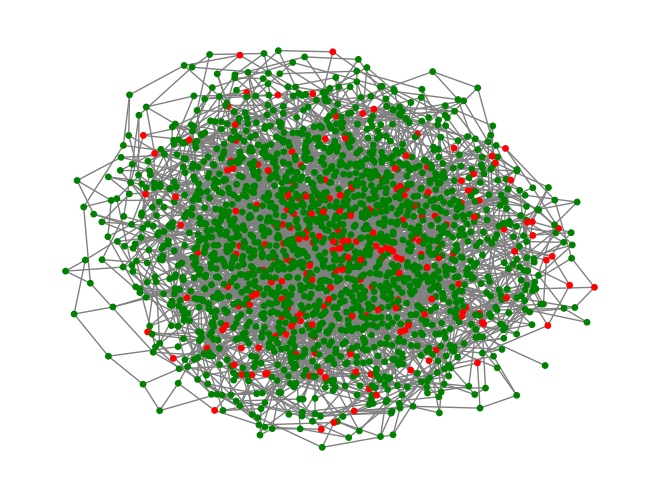

Final disease states: {722: 0, 651: 0, 1430: 0, 1947: 0, 467: 0, 889: 0, 114: 0, 130: 0, 1731: 0, 583: 0, 373: 0, 676: 0, 1738: 0, 157: 0, 1438: 0, 283: 0, 371: 0, 1180: 0, 1205: 0, 138: 0, 477: 0, 1360: 0, 48: 0, 1844: 0, 1578: 0, 1418: 0, 830: 1, 198: 0, 746: 0, 1222: 1, 1080: 0, 1901: 0, 1266: 0, 252: 0, 745: 0, 271: 0, 1897: 1, 51: 0, 1305: 0, 1951: 0, 304: 1, 885: 0, 1866: 0, 1078: 0, 1393: 0, 129: 0, 1113: 0, 1689: 0, 1135: 0, 844: 0, 36: 0, 1268: 0, 423: 0, 1680: 0, 495: 0, 384: 0, 1856: 0, 853: 0, 654: 0, 277: 0, 864: 0, 1908: 0, 1125: 1, 1758: 0, 1349: 0, 541: 0, 1481: 0, 901: 0, 1196: 0, 1494: 0, 284: 0, 1279: 0, 586: 0, 1097: 0, 1472: 0, 139: 0, 659: 0, 456: 0, 133: 0, 708: 1, 918: 0, 414: 0, 563: 0, 734: 0, 1634: 0, 46: 0, 1313: 1, 1224: 0, 1340: 0, 436: 1, 1477: 0, 1970: 0, 470: 0, 1588: 0, 346: 0, 1304: 0, 1359: 0, 1613: 0, 388: 0, 1439: 0, 410: 0, 58: 0, 502: 0, 65: 0, 108: 0, 1733: 0, 1109: 0, 481: 0, 1395: 0, 1147: 0, 397: 1, 1007: 0, 1561: 0, 1183: 0, 1861: 0, 134: 1,

In [55]:
# Test
n = 2000
gamma = 2.7
kmin = 3

degrees = generate_degree_sequence(n, gamma, kmin)
print(degrees)

# Test configuration model
G = generate_configuration_model(degrees)

# Plot the graph
#plt.figure(figsize=(8, 6))
#pos = nx.spring_layout(G, seed=42)
#nx.draw(G, pos, node_size=30, node_color="green", with_labels=False, edge_color="gray", alpha=0.7)
#plt.title("Configuration Model Graph")
#plt.show()

# SIS
states, inf, N_inf, N_e, G2 = OGA_SIS(G, mu=0.2, lam=0.1, max_time=100000, frac_inf=0.05)
color_graph_nodes(states, G2)
print("Final disease states:", states)
print("Final infected nodes: ", inf)
print("Final infected number: ", N_inf)
print("Final infected edges: ", N_e)